In [1]:
from gensim.models import Word2Vec
from dataPreprocess import prepare_data, make_and_save_dict, load_data_and_labels, map_words_and_tags, pad_seq
import pandas as pd
import numpy as np
import pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA

C:\anaconda\envs\tensorflow\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\anaconda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# pre-defined functions to process data
def get_sets(d):
    # convert word2idx, tag2idx to words_set and tags_set in order
    new_dict={v:k for k,v in d.items()}
    new_set = list(new_dict.values())
    return new_set

def prepare_data(filename, num_tags, max_len, word2idx, tag2idx):
    # preprocess data, return padded sequence of X and y
    x_seq, y_seq=load_data_and_labels(filename)
    sent = map_words_and_tags(x_seq, y_seq)
    X, y = pad_seq(word2idx, tag2idx, sent, num_tags, max_len)
    return X, y

In [3]:
# import word dict and tag dict
with open('tag_dict2.pkl', 'rb') as f:
    tag2idx = pickle.load(f)
with open('word_dict2.pkl', 'rb') as f:
    word2idx = pickle.load(f)

num_words = len(word2idx)
num_tags = len(tag2idx)
max_len = 75
words_set = get_sets(word2idx)
tags_set = get_sets(tag2idx)

# prepare train and test data
filename='test.txt'
X_te, y_te = prepare_data(filename, num_tags, max_len, word2idx, tag2idx)
filename = 'train_data.txt'
X_tr, y_tr = prepare_data(filename, num_tags, max_len, word2idx, tag2idx)

In [4]:
# import pre-trained glove embedding
import os
GLOVE_DIR = './glove.6B'
embeddings_index = {} # a dict, key is word, value is the correspond word vector
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index)) # 400000 word vectors

Found 400000 word vectors.


In [48]:
# find corresponsd words in vocab, embedding_matrix is a matrix, every element is the word vector of current index
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word2idx) + 1, EMBEDDING_DIM))
word_list=[]
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        word_list.append(word)
        embedding_matrix[i] = embedding_vector

In [6]:
# use PCA to decrease dimension before using TSNE
pca=PCA(n_components=10)
newdata=pca.fit_transform(embedding_matrix)

# use TSNE
tsne = TSNE(n_components=2, random_state=0)
wv_matrix_2d = tsne.fit_transform(newdata)
print("word_vectors_matrix_2d shape is ", wv_matrix_2d.shape)

word_vectors_matrix_2d shape is  (26871, 2)


In [7]:
word_list=[0]*len(word2idx)
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        word_list[i]=word

points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, wv_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)
print("Points DataFrame built")

Points DataFrame built


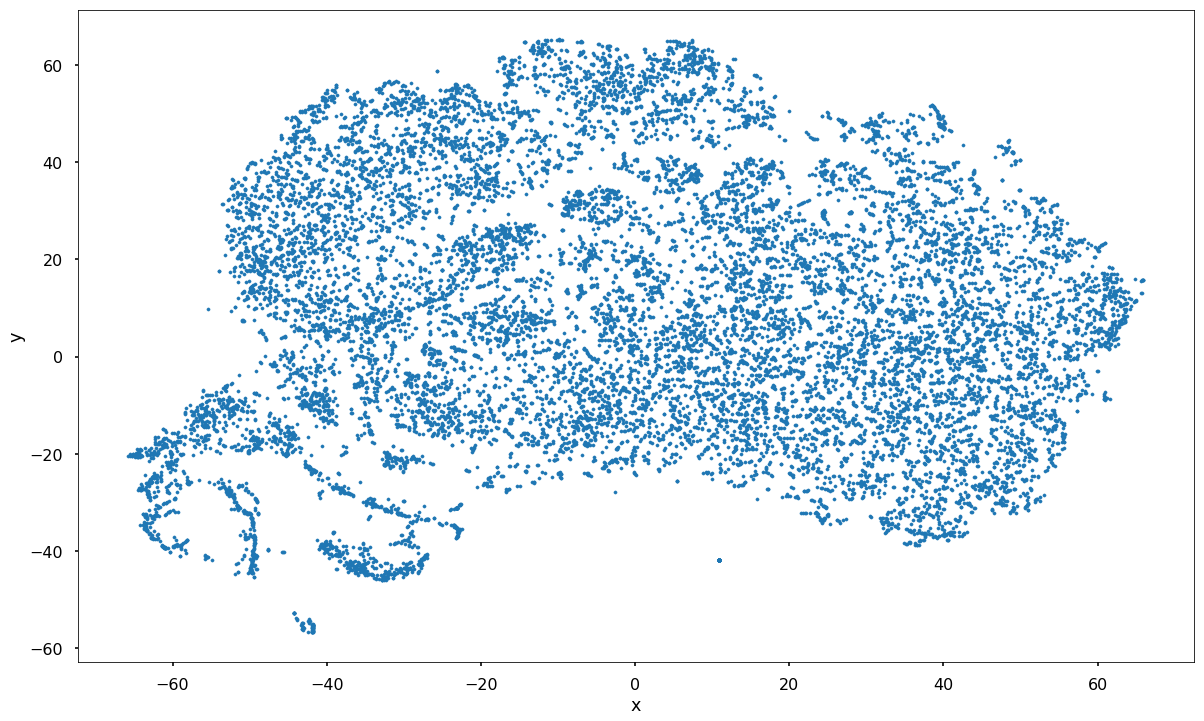

In [70]:
# global embedding figure
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("poster")
points[:20000].plot.scatter("x", "y", s=10, figsize=(20, 12))

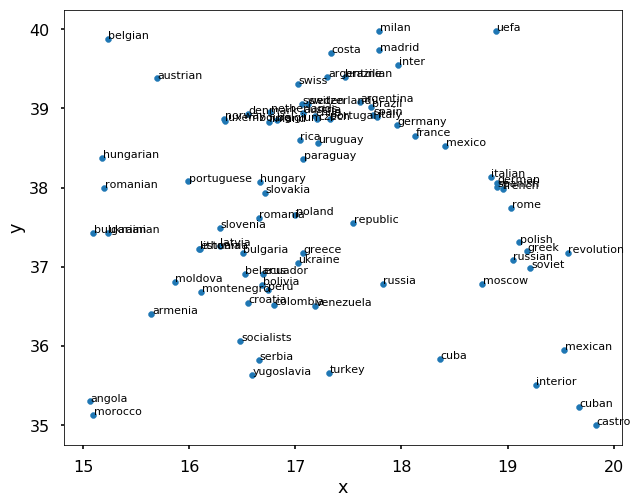

In [16]:
# plot embedding region
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]) 
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
plot_region(x_bounds=(15, 20), y_bounds=(35, 40))

In [5]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [329]:
# train bi-lstm model (without crf)
wv_layer = Embedding(input_dim=len(word2idx)+1, output_dim=EMBEDDING_DIM, mask_zero=False, weights=[embedding_matrix],
                  input_length=max_len, trainable=False) # use pre-trained embedding, the weights won't be changed during training
seq_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = wv_layer(seq_input)
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
bilstm = Bidirectional(LSTM(units=100, return_sequences=True,
                           recurrent_dropout=0.1, use_bias = True))(embedded_sequences)# variational biLSTM
out = TimeDistributed(Dense(num_tags, activation="softmax"))(bilstm)
model_no_crf = Model([seq_input], out)
model_no_crf.summary()
# save the model
model_no_crf.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model_no_crf.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)
model_no_crf.save('828model_glove.h5')
model_no_crf.save_weights('828model_weights_glove.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 100)           2687100   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 75, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 200)           160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 9)             1809      
Total params: 2,849,709
Trainable params: 162,609
Non-trainable params: 2,687,100
_________________________________________________________________
Train on 18668 samples, validate on 2075 samples
Epoch 1/5
18668/18668 [==============================] - 88s 5ms/step - loss:

In [88]:
# Load the model from local
from keras.models import load_model
model_no_crf = load_model('828model_glove.h5')
model_no_crf.load_weights('828model_weights_glove.h5')

In [846]:
# randomly choose an example sentence to check the prediction of the model
exp=307
p = model_no_crf.predict(np.array([X_te[exp]]))
p = np.argmax(p, axis=-1)
print('prediction: ')
print(p[0])

test_true = np.argmax(y_te[exp], -1)
print('true results:')
print(test_true)

seq_len=0
print("{:15} ({:5}): {:5}".format("Word", "True", "pred"))
for w, t, pred in zip(X_te[exp], test_true, p[0]):
    if w != 0:
        seq_len += 1
        print("{:15}: {:5} {:5}".format(words_set[w-1], tags_set[t], tags_set[pred]))

prediction: 
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5]
true results:
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5]
Word            (True ): pred 
"              : O     O    
i              : O     O    
do             : O     O    
not            : O     O    
want           : O     O    
to             : O     O    
say            : O     O    
that           : O     O    
there          : O     O    
is             : O     O    
a              : O     O    
concrete       : O     O    
danger         : O     O    
for            : O     O    
consumers      : O     O    
,              : O     O    
"              : O     O    
he             : O     O    
added          : O     O    
.              : O     O    
"              : O     O    


In [666]:
# get all weights and biases of the model
weights1 = model_no_crf.layers[1].get_weights()
weights2 = model_no_crf.layers[3].get_weights()
weights3 = model_no_crf.layers[4].get_weights()

# Init phase
units_num = 100 # lstm units number

# embedding
E = model_no_crf.layers[1].get_weights()[0]# embedding matrix, shape [len(word_dict), word_vec_dim]

# left encoder
''' parameter setting:
weights from embedding layer to 1st layer left direction lstm cells: weights[0]
weights from lstem layer to 2st lstm layer: weights[1]
biases of left encoder of four gates
weights i -- 0-50, weights f -- 51-100, weights c -- 100-150, weights o -- 150-200
bias has the same order: i,c,f,o, each length 50
'''
Wxh_Left = weights2[0].T # (100, 400), embedding_size * 4*lstm_units_num
Whh_Left = weights2[1].T # (100, 400), lstm_units_num * 4*lstm_units_num
b_Left = weights2[2] # (400, ), biases of i, f, c, o gates

# Right encoder, parameters setting is similar with left encoder
Wxh_Right = weights2[3].T
Whh_Right = weights2[4].T
b_Right = weights2[5]

# softmax
Why_Left = weights3[0][:units_num].T # weights3[0] 's dimension: (100, 9)
Why_Right = weights3[0][units_num:].T#[::-1,:].copy()
hy_biases = weights3[1] # (9,)

In [667]:
# setup phase
seq_test = X_te[exp][:seq_len]
T = len(seq_test) # extract non-0 word_indice
d = int(Wxh_Left.shape[0]/4)
e = E.shape[1]
x = np.zeros((T, e)) 
x[:,:] = E[seq_test,:]
x_rev = x[::-1,:].copy()
#if delete_pos is not None:
#    x[delete_pos, :] = np.zeros((len(delete_pos), e))  # to erase a dimension
h_Left = np.zeros((T+1, d))
c_Left = np.zeros((T+1, d))
h_Right = np.zeros((T+1, d))
c_Right = np.zeros((T+1, d))

In [668]:
# forward phase
idx = np.hstack((np.arange(0,2*d), np.arange(3*d,4*d))).astype(int) # indexes of gates i, f, o

# initialize
gates_xh_Left  = np.zeros((T, 4*d))
gates_hh_Left  = np.zeros((T, 4*d))
gates_pre_Left = np.zeros((T, 4*d))
gates_Left     = np.zeros((T, 4*d))

gates_xh_Right  = np.zeros((T, 4*d))
gates_hh_Right  = np.zeros((T, 4*d))
gates_pre_Right = np.zeros((T, 4*d))
gates_Right     = np.zeros((T, 4*d))

for t in range(T):
    gates_xh_Left[t] = np.dot(Wxh_Left, x[t])# W*X
    gates_hh_Left[t] = np.dot(Whh_Left, h_Left[t-1]) # H*X
    gates_pre_Left[t] = gates_xh_Left[t] + gates_hh_Left[t] + b_Left  # gates i, f, c, o: W*X + H*X + b, H is the last hidden state
    gates_Left[t, idx] = 1.0/(1.0 + np.exp(- gates_pre_Left[t,idx])) # gates i, f, o use sigmoid activation
    gates_Left[t, 2*d:3*d] = np.tanh(gates_pre_Left[t, 2*d:3*d]) # gates c use tanh activation
    c_Left[t] = gates_Left[t, d:2*d] * c_Left[t-1] + gates_Left[t, :d] * gates_Left[t, 2*d:3*d] #ct = ft*c(t-1) + it*ct
    h_Left[t] = gates_Left[t, 3*d:] * np.tanh(c_Left[t])#h = ot*tanh(Ct)
    
    gates_xh_Right[t] = np.dot(Wxh_Right, x[t]) # W*X # maybe x_rev[t]
    gates_hh_Right[t] = np.dot(Whh_Right, h_Right[t-1])# H*X
    gates_pre_Right[t] = gates_xh_Right[t] + gates_hh_Right[t] + b_Right  # gates i, f, c, o: W*X + H*X + b, H is the last hidden state
    gates_Right[t, idx] = 1.0/(1.0 + np.exp(- gates_pre_Right[t,idx])) # gates i, f, o use sigmoid activation
    gates_Right[t, 2*d:3*d] = np.tanh(gates_pre_Right[t, 2*d:3*d]) # gates c use tanh activation
    c_Right[t] = gates_Right[t, d:2*d] * c_Right[t-1] + gates_Right[t, :d] * gates_Right[t, 2*d:3*d] #ct = ft*c(t-1) + it*ct
    h_Right[t] = gates_Right[t, 3*d:] * np.tanh(c_Right[t])#h = ot*tanh(Ct)

In [670]:
# scores of prediction of labels for each word of the input sentence
scores_sequence = []
for t in range(T):
    s_Left = np.dot(Why_Left, h_Left[t])+hy_biases
    s_Right = np.dot(Why_Right, h_Right[t])+hy_biases
    score = s_Left + s_Right
    scores_sequence.append(score)

true = np.argmax(y_te[exp], -1)
be = np.argmax(scores_sequence, axis=-1) 
print(true)
print(be)
print("{:15} {:5} {:5} {:10}".format("Word", "True", "simulated", "pred"))
for w_id, true_tag_id, pr, pred in zip(seq_test, true, be, p[0]):
    print("{:15}: {:5} {:5} {:10}".format(words_set[w_id-1], tags_set[true_tag_id], tags_set[pr], tags_set[pred]))

# assign the output vector as the relevance score of the output layer
s=scores_sequence[T-1]

[5 5 8 0 5 5 5 5 8 5 5 5 5 3 5 8 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5]
[7 5 8 0 5 5 5 5 8 5 5 5 5 3 5 8 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Word            True  simulated pred      
tour           : O     O     O         
manager        : O     O     O         
clive          : B-PER B-PER B-PER     
lloyd          : I-PER I-PER I-PER     
on             : O     O     O         
wednesday      : O     O     O         
apologised     : O     O     O         
for            : O     O     O         
lara           : B-PER B-PER B-PER     
's             : O     O     O         
behaviour      : O     O     O         
in             : O     O     O         
confronting    : O     O     O         
australia      : B-LOC B-LOC B-LOC     
coach          : O     O     O         
geoff          : B-PER B-PER B-PER     
marsh          : I-PER I-PER I-PER     
in             : O     O     O         
the          

In [760]:
# Calculate relevance score for each unit in each layer
from lrp_cal.py import lrp_linear 
C = Why_Left.shape[0]  # number of classes (tags), here is 9
idx = np.hstack((np.arange(0,2*d), np.arange(3*d,4*d))).astype(int) 
eps                 = 0.001
bias_factor         = 0 #1
# initialize
Rx       = np.zeros(x.shape)
Rx_rev   = np.zeros(x.shape)

Rh_Left  = np.zeros((T+1, d))
Rc_Left  = np.zeros((T+1, d))
Rg_Left  = np.zeros((T,   d)) # gate g only
Rh_Right = np.zeros((T+1, d))
Rc_Right = np.zeros((T+1, d))
Rg_Right = np.zeros((T,   d)) # gate g only

Rout_mask            = np.zeros((C))
Rout_mask[np.argmax(scores_sequence[-1])] = 1.0  

Rh_Left[T-1]  = lrp_linear(h_Left[T-1],  Why_Left.T , hy_biases, s, s*Rout_mask, 2*d, eps, bias_factor, debug=False)
Rh_Right[T-1] = lrp_linear(h_Right[T-1], Why_Right.T, hy_biases, s, s*Rout_mask, 2*d, eps, bias_factor, debug=False)

# Rh shape (sentence_length, units_num), represents the relevance score of every units of every word in hidden layer
# Rx shape (sentence_length, units_num), each represents the relevance score of every word embedding dimension of every word
for t in reversed(range(T)):
    Rc_Left[t]   += Rh_Left[t]
    Rc_Left[t-1]  = lrp_linear(gates_Left[t,d:2*d]*c_Left[t-1], np.identity(d), np.zeros((d)), c_Left[t], Rc_Left[t], 2*d, eps, bias_factor, debug=False)
    Rg_Left[t]    = lrp_linear(gates_Left[t,0:d]*gates_Left[t,2*d:3*d], np.identity(d), np.zeros((d)), c_Left[t], Rc_Left[t], 2*d, eps, bias_factor, debug=False)
    Rx[t]         = lrp_linear(x[t], Wxh_Left[2*d:3*d].T, b_Left[2*d:3*d], gates_pre_Left[t,2*d:3*d], Rg_Left[t], d+e, eps, bias_factor, debug=False)
    Rh_Left[t-1]  = lrp_linear(h_Left[t-1], Whh_Left[2*d:3*d].T, b_Left[2*d:3*d], gates_pre_Left[t,2*d:3*d], Rg_Left[t], d+e, eps, bias_factor, debug=False)

    Rc_Right[t]   += Rh_Right[t]
    Rc_Right[t-1]  = lrp_linear(gates_Right[t,d:2*d]*c_Right[t-1], np.identity(d), np.zeros((d)), c_Right[t], Rc_Right[t], 2*d, eps, bias_factor, debug=False)
    Rg_Right[t]    = lrp_linear(gates_Right[t,0:d]*gates_Right[t,2*d:3*d], np.identity(d), np.zeros((d)), c_Right[t], Rc_Right[t], 2*d, eps, bias_factor, debug=False)
    Rx_rev[t]         = lrp_linear(x_rev[t], Wxh_Right[2*d:3*d].T, b_Right[2*d:3*d], gates_pre_Right[t,2*d:3*d], Rg_Right[t], d+e, eps, bias_factor, debug=False)
    Rh_Right[t-1]  = lrp_linear(h_Right[t-1], Whh_Right[2*d:3*d].T, b_Right[2*d:3*d], gates_pre_Right[t,2*d:3*d], Rg_Right[t], d+e, eps, bias_factor, debug=False)

australia


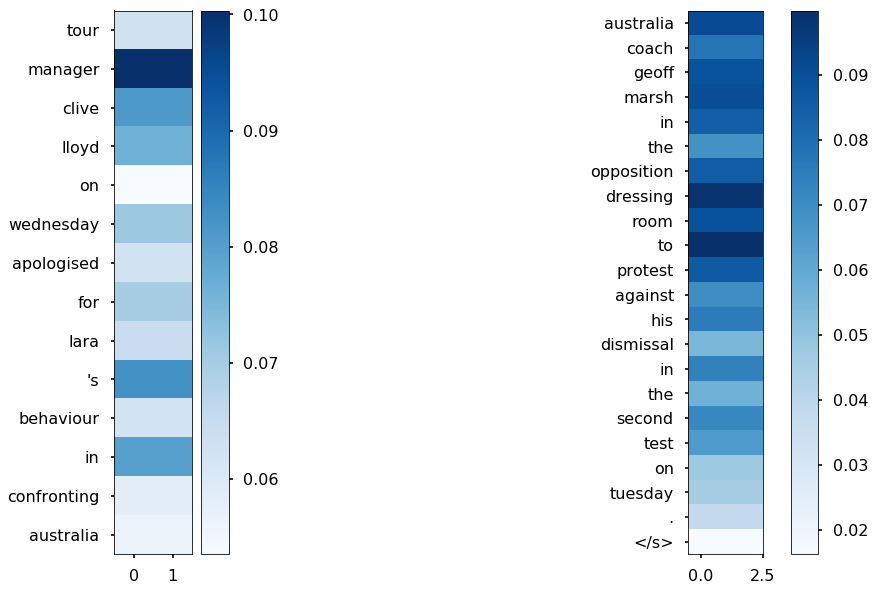

In [763]:
import matplotlib.pylab as plt
import matplotlib as mpl
w_list=[words_set[w-1] for w in seq_test]
w_list.append('</s>')
check_word_idx=14
print(w_list[check_word_idx-1])

matrix_left = Rh_Left[:check_word_idx].sum(axis=1)
matrix_l=np.zeros((matrix_left.shape[0],2))
for i in range(matrix_left.shape[0]):
    for j in range(2):
        matrix_l[i,j]=matrix_left[i]

matrix_right = Rh_Right[:-check_word_idx+1].sum(axis=1)[::-1]
matrix_r=np.zeros((matrix_right.shape[0],3))
for i in range(matrix_right.shape[0]):
    for j in range(3):
        matrix_r[i][j]=matrix_right[i]

# show the generated tag of each word contributes to the predicted tag for the targed word (here is 'australia')
# the left figure shows the relevance scores for each word in forward states
# the right figure shows the relevance scores for each word in backward states
fig,(ax, ax2)=plt.subplots(ncols=2, figsize=(15,10), gridspec_kw={"width_ratios":[1,3]})
ax.set_yticks(np.arange(len(matrix_left)))
ax.set_yticklabels(w_list[:check_word_idx])
im1=ax.imshow(matrix_l, cmap=plt.cm.Blues)
fig.colorbar(im1, ax=ax)

ax2.set_yticks(np.arange(len(matrix_right)))
ax2.set_yticklabels(w_list[check_word_idx-1:])
im2=ax2.imshow(matrix_r, cmap=plt.cm.Blues)
fig.colorbar(im2, ax=ax2)
plt.show()

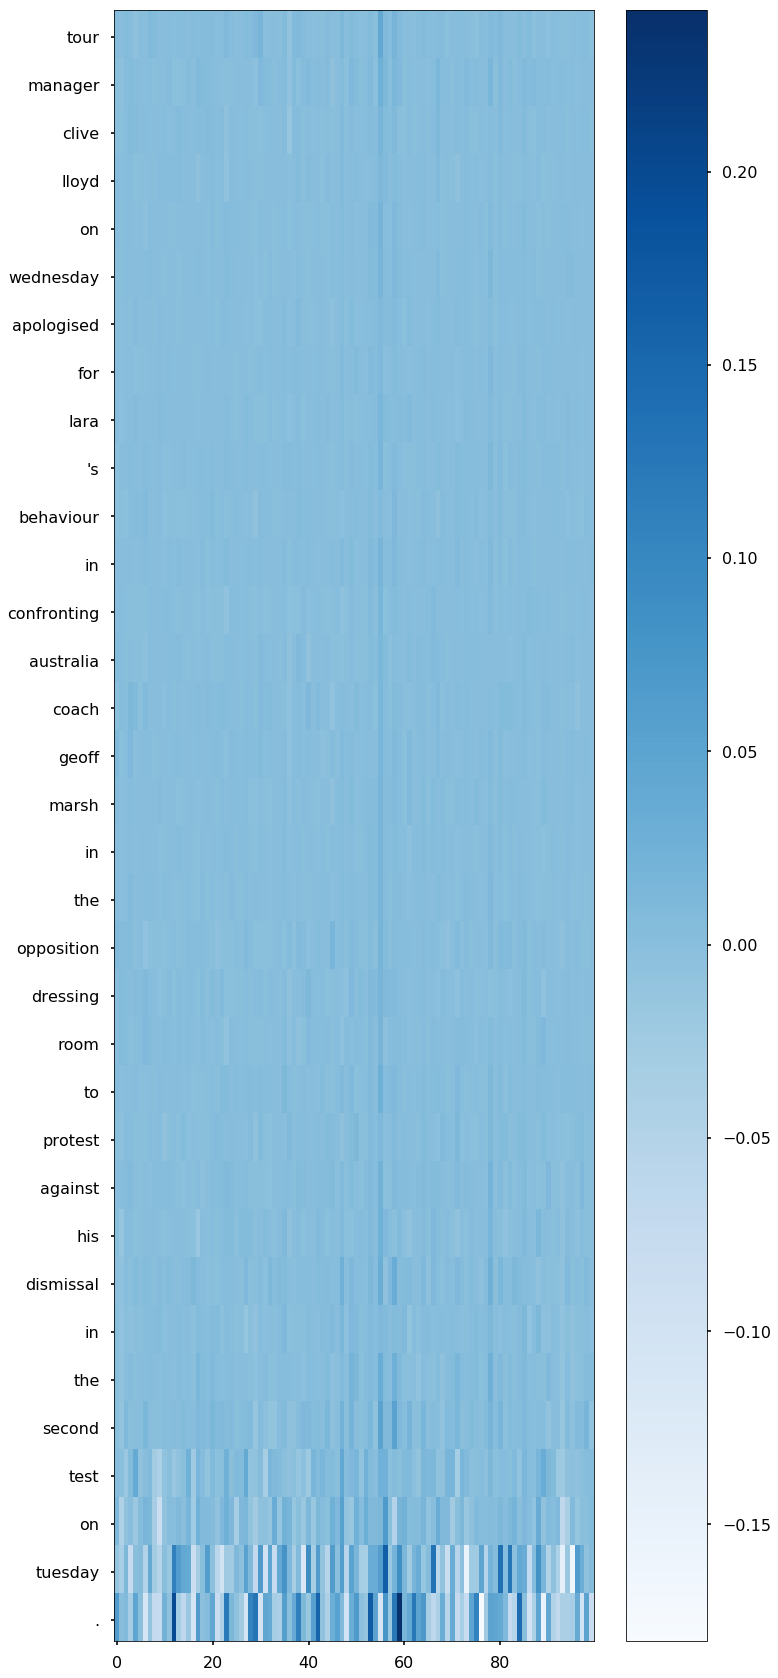

In [737]:
# Show the contribution from each dimension of word vectors to the last hidden state
matrix=Rx[:]+Rx_rev[:]
matrix_magnify_left=np.zeros((matrix.shape[0]*10,matrix.shape[1]))
matrix_magnify=np.zeros((matrix.shape[0]*10,matrix.shape[1]))        
for i in range(matrix.shape[0]):
    for j in range(10):
        matrix_magnify[i*10+j,:]=matrix[i,:]
        
fig = plt.figure()
fig.set_size_inches(25,30)
ax = fig.add_subplot(1,2,1)
ax.set_yticks(np.arange(5, len(matrix_magnify)*10, 10))
ax.set_yticklabels(w_list)
plt.imshow(matrix_magnify, interpolation='Nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

clive


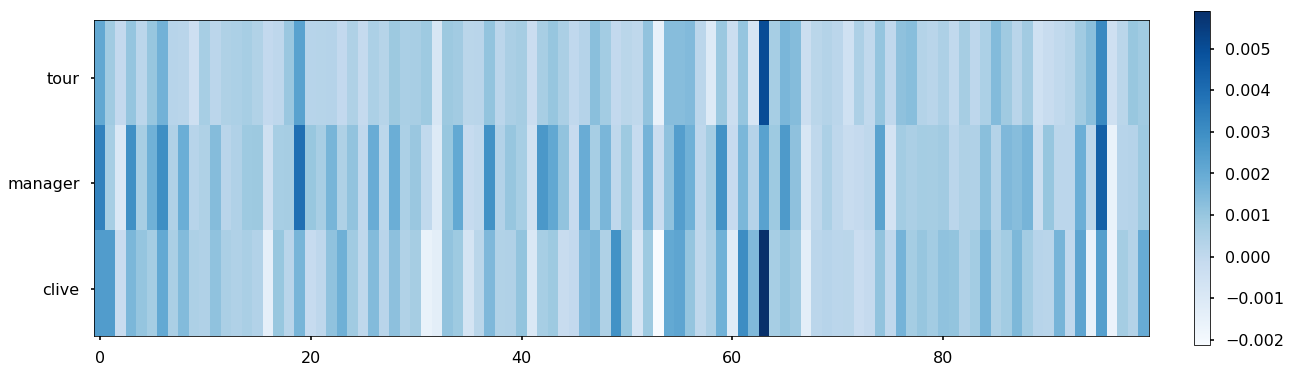

In [743]:
check_word_idx=3
print(w_list[check_word_idx-1])
# fig for left side
matrix_left = Rh_Left[:check_word_idx]#.sum(axis=1)
matrix_l=np.zeros((matrix_left.shape[0]*10,matrix_left.shape[1]))
for i in range(matrix_left.shape[0]):
    for j in range(10):
        matrix_l[i*10+j,:]=matrix_left[i,:]

fig,ax=plt.subplots()
#im=ax.imshow(matrix_l)
#fig.set_size_inches(10,5)
ax.set_yticks(np.arange(5, len(matrix_left)*10, 10))
ax.set_yticklabels(w_list[:check_word_idx])
fig.set_size_inches(20,20)
plt.imshow(matrix_l, interpolation='Nearest', cmap=plt.cm.Blues)
plt.colorbar(fraction=0.015, pad=0.04)
plt.show()

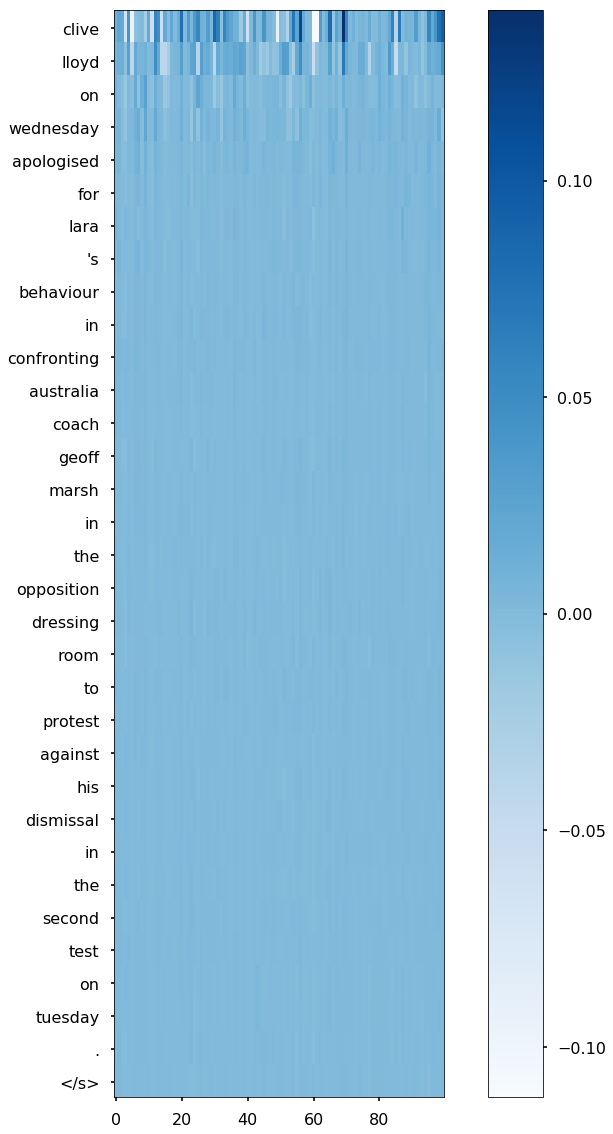

69

In [742]:
# figure for right side
matrix_right = Rh_Right[:-check_word_idx+1][::-1]#.sum(axis=1)[::-1]
matrix_r=np.zeros((matrix_right.shape[0]*10,matrix_right.shape[1]))
for i in range(matrix_right.shape[0]):
    for j in range(10):
        matrix_r[i*10+j:]=matrix_right[i,:]
fig,ax=plt.subplots()
ax.set_yticks(np.arange(5, len(matrix_right)*10, 10))
ax.set_yticklabels(w_list[check_word_idx-1:])
fig.set_size_inches(20,20)
plt.imshow(matrix_r, interpolation='Nearest', cmap=plt.cm.Blues)
plt.colorbar(fraction=0.15, pad=0.04)
plt.show()
np.argmax(matrix_right[0])

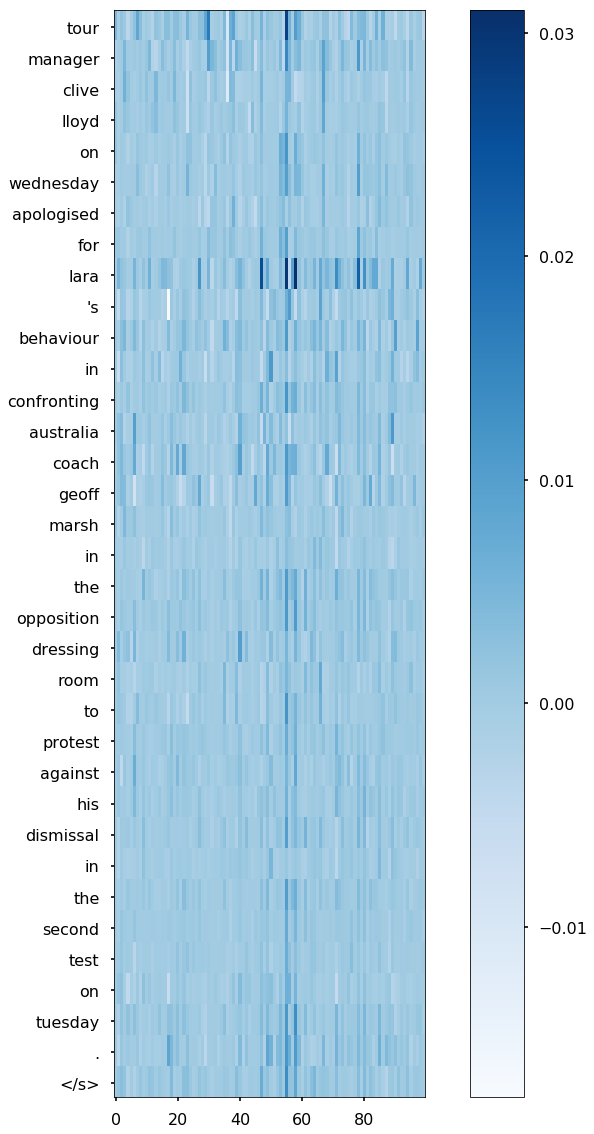

In [736]:
matrix_word = np.concatenate((matrix_left, matrix_right), axis=0)
matrix_w=np.zeros((matrix_word.shape[0]*10,matrix_word.shape[1]))
for i in range(matrix_word.shape[0]):
    for j in range(10):
        matrix_w[i*10+j:]=matrix_word[i,:]
fig,ax=plt.subplots()
ax.set_yticks(np.arange(5, len(matrix_word)*10, 10))
ax.set_yticklabels(w_list)
fig.set_size_inches(20,20)
plt.imshow(matrix_w, interpolation='Nearest', cmap=plt.cm.Blues)
plt.colorbar(fraction=0.15, pad=0.04)
plt.show()

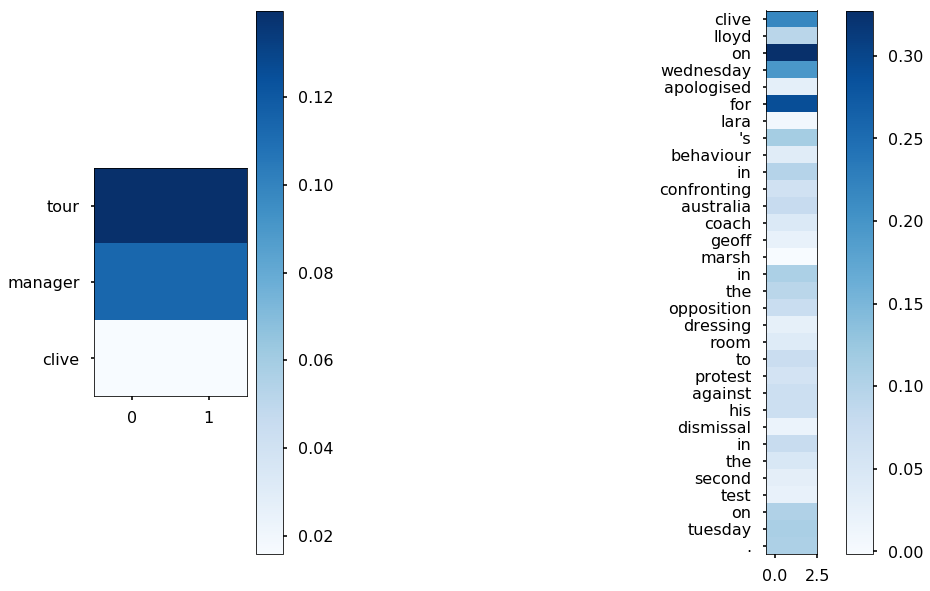

In [756]:
matrix_left = Rx[:check_word_idx].sum(axis=1)
matrix_l=np.zeros((matrix_left.shape[0],2))
for i in range(matrix_left.shape[0]):
    for j in range(2):
        matrix_l[i,j]=matrix_left[i]

matrix_right = Rx_rev[:-check_word_idx+1].sum(axis=1)[::-1]
matrix_r=np.zeros((matrix_right.shape[0],3))
for i in range(matrix_right.shape[0]):
    for j in range(3):
        matrix_r[i][j]=matrix_right[i]

fig,(ax, ax2)=plt.subplots(ncols=2, figsize=(15,10), gridspec_kw={"width_ratios":[1,3]})
ax.set_yticks(np.arange(len(matrix_left)))
ax.set_yticklabels(w_list[:check_word_idx])
im1=ax.imshow(matrix_l, cmap=plt.cm.Blues)
fig.colorbar(im1, ax=ax)

ax2.set_yticks(np.arange(len(matrix_right)))
ax2.set_yticklabels(w_list[check_word_idx-1:])
im2=ax2.imshow(matrix_r, cmap=plt.cm.Blues)
fig.colorbar(im2, ax=ax2)
plt.show()


In [8]:
# train bilstm-crf model
from keras_contrib.layers import CRF
input = Input(shape=(max_len,))
model_crf = Embedding(input_dim=len(word2idx)+1, output_dim=EMBEDDING_DIM,input_length=max_len, mask_zero=True)(input)  # 100-dim embedding
model_crf =  Bidirectional(LSTM(units=100, return_sequences=True,recurrent_dropout=0.1, use_bias = True))(model_crf)  # variational biLSTM
model_crf = TimeDistributed(Dense(num_tags, activation="sigmoid"))(model_crf)  # a dense layer as suggested by neuralNer
crf = CRF(num_tags)  # CRF layer
out = crf(model_crf)  # output
model_crf = Model(input, out)
# save the model
model_crf.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
history = model_crf.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)
from keras_contrib.utils import save_load_utils
save_load_utils.save_all_weights(model_crf, '910crfmodel_allweights.h5', include_optimizer=False)

In [10]:
# load all weights of the model with crf layer
from keras_contrib.utils import save_load_utils
weights_crf=save_load_utils.load_all_weights(model_crf, '910crfmodel_allweights.h5')

In [11]:
model_crf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 100)           2687100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 200)           160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 9)             1809      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 9)             189       
Total params: 2,849,898
Trainable params: 2,849,898
Non-trainable params: 0
_________________________________________________________________


In [27]:
test_exp=580
bilstm_layer = Model(inputs=model_crf.input, outputs=model_crf.get_layer('time_distributed_1').output)
bilstm_output = bilstm_layer.predict(np.array([X_te[test_exp]]))
biout = np.argmax(bilstm_output,axis=-1)
print('bilstm results: ')
print(biout[0])

crf_layer = Model(inputs=model_crf.input, outputs=model_crf.get_layer('crf_1').output)
crf_output = crf_layer.predict(np.array([X_te[test_exp]]))
crfout = np.argmax(crf_output,axis=-1)
print('crf layer results: ')
print(crfout[0])
p = model_crf.predict(np.array([X_te[test_exp]]))
p = np.argmax(p, axis=-1)
print('prediction: ')
print(p[0])
time_dis_layer5 = Model(inputs=model_crf.input, outputs=model_crf.get_layer('time_distributed_1').output)
bilstm_output = bilstm_layer.predict(np.array([X_te[test_exp]]))
emission_matrix = np.dot(bilstm_output[0], weights_crf_kernel) + crf_bias
emission_list = np.argmax(emission_matrix,axis=1)
print('emission results')
print('')
test_true = np.argmax(y_te[test_exp], -1)
print('true results:')
print(test_true)
print("{:15} ({:5}): {:5} {:5} {:5}".format("Word", "True", "bilstm-out", "emission", "crfout"))
for w, t, bilstm_pred, emission_pred, crf_pred in zip(X_te[test_exp], test_true, biout[0], emission_list, p[0]):
    if w != 0:
        print("{:15}: {:7} {:10} {:8} {:5}".format(words_set[w-1], tags_set[t], tags_set[bilstm_pred], tags_set[emission_pred], tags_set[crf_pred]))

bilstm results: 
[1 8 6 5 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5]
crf layer results: 
[6 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
prediction: 
[6 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
emission results

true results:
[6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5]
Word            (True ): bilstm-out emission crfout
utrecht        : B-ORG   I-MISC     I-LOC    B-ORG
18             : O       B-PER      I-PER    O    
4              : O       B-ORG      I-PER    O    
10             : O       O          I-PER    O    
4              : O       O          I-PER    O

{'B-LOC': 3,
 'B-MISC': 7,
 'B-ORG': 6,
 'B-PER': 8,
 'I-LOC': 2,
 'I-MISC': 1,
 'I-ORG': 4,
 'I-PER': 0,
 'O': 5}

In [14]:
for e in zip(model_crf.layers[4].trainable_weights, model_crf.layers[4].get_weights()):
    print('Param %s:\n%s' % (e[0],e[1]))
    
weights_crf_kernel = model_crf.layers[4].get_weights()[0]
weights_crf_chain = model_crf.layers[4].get_weights()[1]
crf_bias = model_crf.layers[4].get_weights()[2]
left_boundary_bias = model_crf.layers[4].get_weights()[3]
right_boundary_bias = model_crf.layers[4].get_weights()[4]

Param <tf.Variable 'crf_1/kernel:0' shape=(9, 9) dtype=float32_ref>:
[[ 1.28573    -0.58258027 -0.26503798  1.4199113   0.5900098  -0.9221122
   0.5827867  -0.13947262  1.1070527 ]
 [ 0.8954092   0.6866215   0.93099827 -1.1967978   0.6270601   1.0023032
  -1.4442679  -0.81023085 -0.9479818 ]
 [ 0.9957231   0.35401425  0.68588126  1.0108445   0.82220036 -0.99758476
   0.815036    0.7269303  -1.0758635 ]
 [ 0.49714902  0.21866246 -0.04788284 -1.1849245   1.031813   -0.8291999
   0.28225785  0.45972496  0.69353855]
 [ 0.99400026 -0.76046395 -1.0593885  -1.7299538   0.03058998  0.5254574
   1.1938846  -0.75969     0.91804767]
 [ 0.45348477  0.30284566  0.9434663   0.6173072  -0.42587397 -0.7851631
  -1.0453266   1.175385   -0.3428483 ]
 [-0.66790795  0.7652986   0.8141825   1.1295207  -0.24729994 -0.3806564
   1.3023026   0.93570966 -0.3056632 ]
 [-1.361307   -0.8457315   0.4277054   1.5718122   0.59399456  0.5465151
  -0.983393   -1.1982867  -0.9629235 ]
 [ 1.471428    0.6144372  -0.12430

In [16]:
time_dis_layer5 = Model(inputs=model_crf.input, outputs=model_crf.get_layer('time_distributed_1').output)
bilstm_output = bilstm_layer.predict(np.array([X_te[test_exp]]))
emission_matrix = np.dot(bilstm_output[0], weights_crf_kernel) + crf_bias
emission_list = np.argmax(emission_matrix,axis=1)

In [1089]:
crf_input_matrix = np.insert(bilstm_output[0], 0, values = left_boundary_bias, axis=0)

In [1090]:
emssion = np.dot(crf_input_matrix, weights_crf_kernel) + crf_bias